# Our task is to predict the letter giving the hand sign picture.
We don't have a specific question to choose which performance metric is better so we use all of them (including precision, accuracy, recall and f1-score).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA
from sklearn.multiclass import OneVsOneClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from skimage.feature import hog
from skimage import exposure
from skimage.transform import rotate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from joblib import Parallel, delayed
import cv2
%matplotlib inline

In [2]:
pre_train = pd.read_csv('sign_mnist_train.csv')
pre_test = pd.read_csv('sign_mnist_test.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'sign_mnist_train.csv'

**TAKE A LOOK**

In [ ]:
pre_train.head()

In [ ]:
#CHECK FOR NULL
print(pre_train.isnull().sum())
print(pre_test.isnull().sum())

In [ ]:
train_set, val_set = train_test_split(pre_train, test_size=0.3,stratify=pre_train["label"], random_state=42)

In [ ]:
def process_raw_file_into_dataset_and_label(df_link, hist=False):
    # check filename or DataFrame
    if isinstance(df_link, str):
        df = pd.read_csv(df_link)
    elif isinstance(df_link, pd.DataFrame):
        df = df_link
    else:
        raise ValueError("Input must be a file path or a pandas DataFrame")

    # separate label
    labels = df['label'].values

    #delete label column
    pixels = df.drop(columns=['label']).values
    pixels = pixels.astype(np.float64)

    return pixels, labels


In [ ]:
# read data from csv file
X_train, y_train = process_raw_file_into_dataset_and_label(train_set)
X_val, y_val = process_raw_file_into_dataset_and_label(val_set)
X_test, y_test = process_raw_file_into_dataset_and_label(pre_test)

# normalize data from 0 to 1 range
X_train = X_train/255
X_val = X_val/255
X_test = X_test/255

Prepare augmented_data for CNN that we have already made in HOG

In [ ]:
augmented_data = np.array(pd.read_csv("augmented_data.csv"))
augmented_labels = np.array(pd.read_csv("augmented_label.csv"))

In [ ]:
augmented_labels1 = np.squeeze(augmented_labels)

Concatenate data

In [ ]:
X_train_DCT_augmented_data = np.vstack((augmented_data, X_train))
y_train_DCT_augmented_data = np.concatenate((augmented_labels1, y_train))

# There is a more efficiency for image classtification and that is Convolutional Neural Network

In [ ]:
from skimage import data,exposure
from skimage.io import imshow,imread
from skimage.transform import resize
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense,Input,Conv2D,MaxPool2D,Flatten,Dropout , BatchNormalization
from keras.callbacks import ReduceLROnPlateau
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model

LOAD DATA FOR CNN

In [ ]:
print(X_test.shape)

In [ ]:
X_train_CNN = X_train.reshape(19218, 28, 28, 1)
X_validation_CNN = X_val.reshape(8237, 28, 28, 1)
X_test_CNN = X_test.reshape(7172, 28, 28, 1)

Data agumentation to avoid overfiiting . It basically generates new picture (feature) . It take the data set and randomly rotate the picture or shift the picture ,..

In [ ]:
datagen_CNN = ImageDataGenerator(
        rotation_range=10,  # randomly rotate images
        zoom_range = 0.1, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally
        height_shift_range=0.1,  # randomly shift images vertically
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False  # randomly flip images
)
datagen_CNN.fit(X_train_CNN)

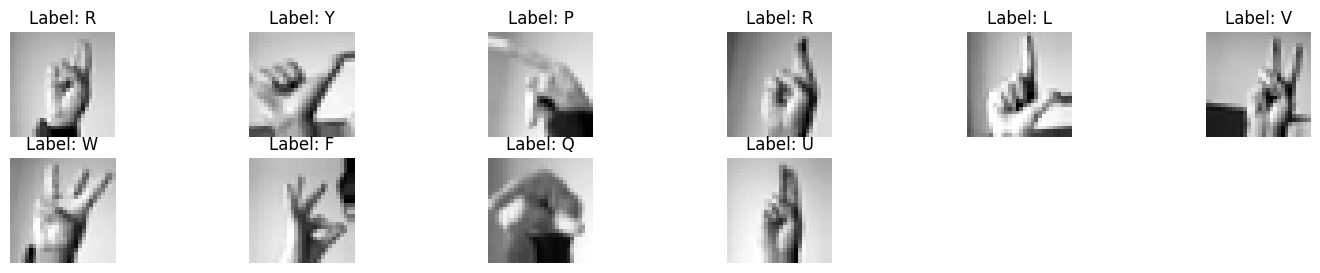

transform the y_data to the category type.

In [ ]:
y_train_CNN = to_categorical(y_train,25)
y_valdidation_CNN = to_categorical(y_val,25)

print(y_train_CNN.shape)
print(y_valdidation_CNN.shape)

The activation function introduces non-linearity into the network and allowing it to learn complex patterns and relationships in the data . Moreover, there are many other activation function but reLU is the most common one becasue it  speed up the calculation .

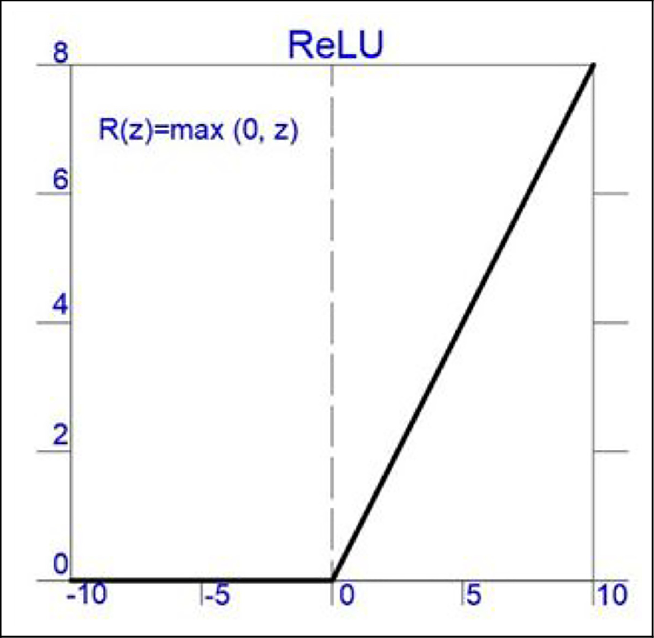

this is called the convolution . In this CNN , we basically take the matrix and multiply component-wise with the kernel (We can set how many kernel we want)and sum all them . This step reduce the dimension, extract the feature in order to allow the network to focus on local regions of the image

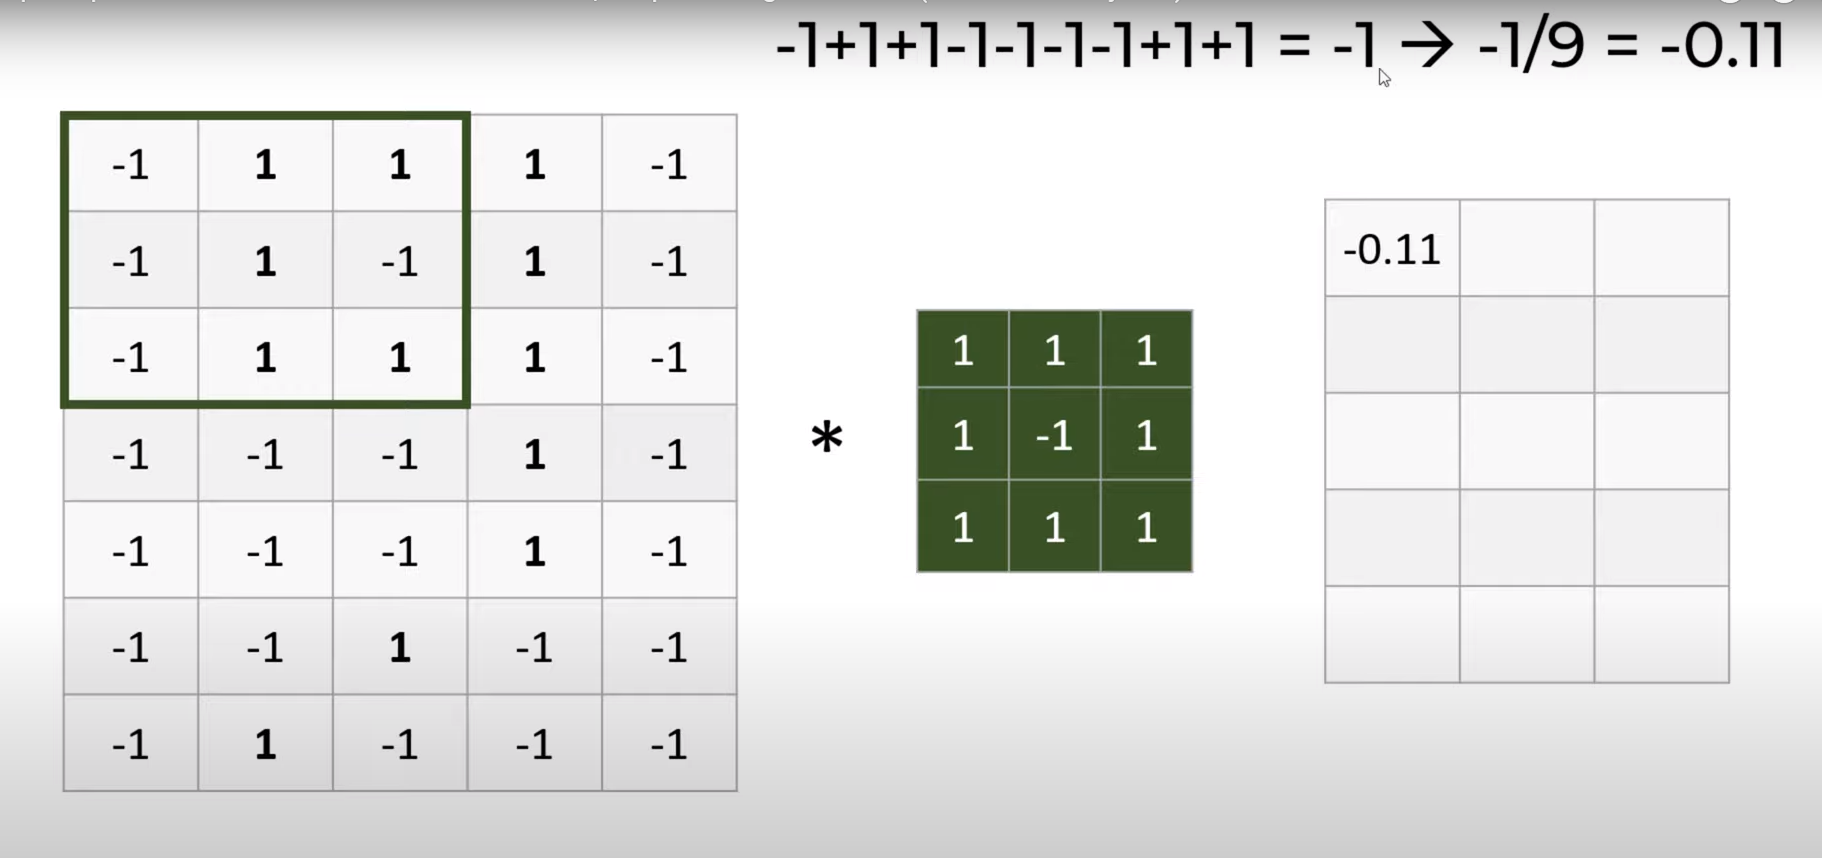

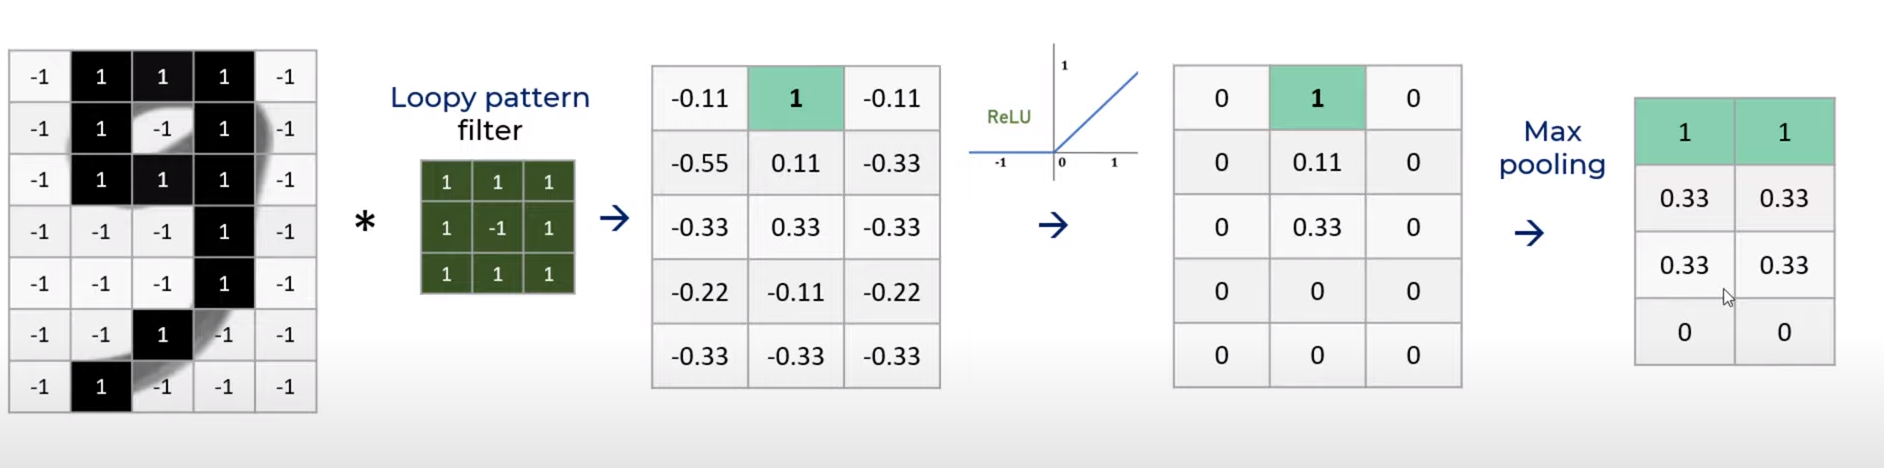

here is why we use the max poling .

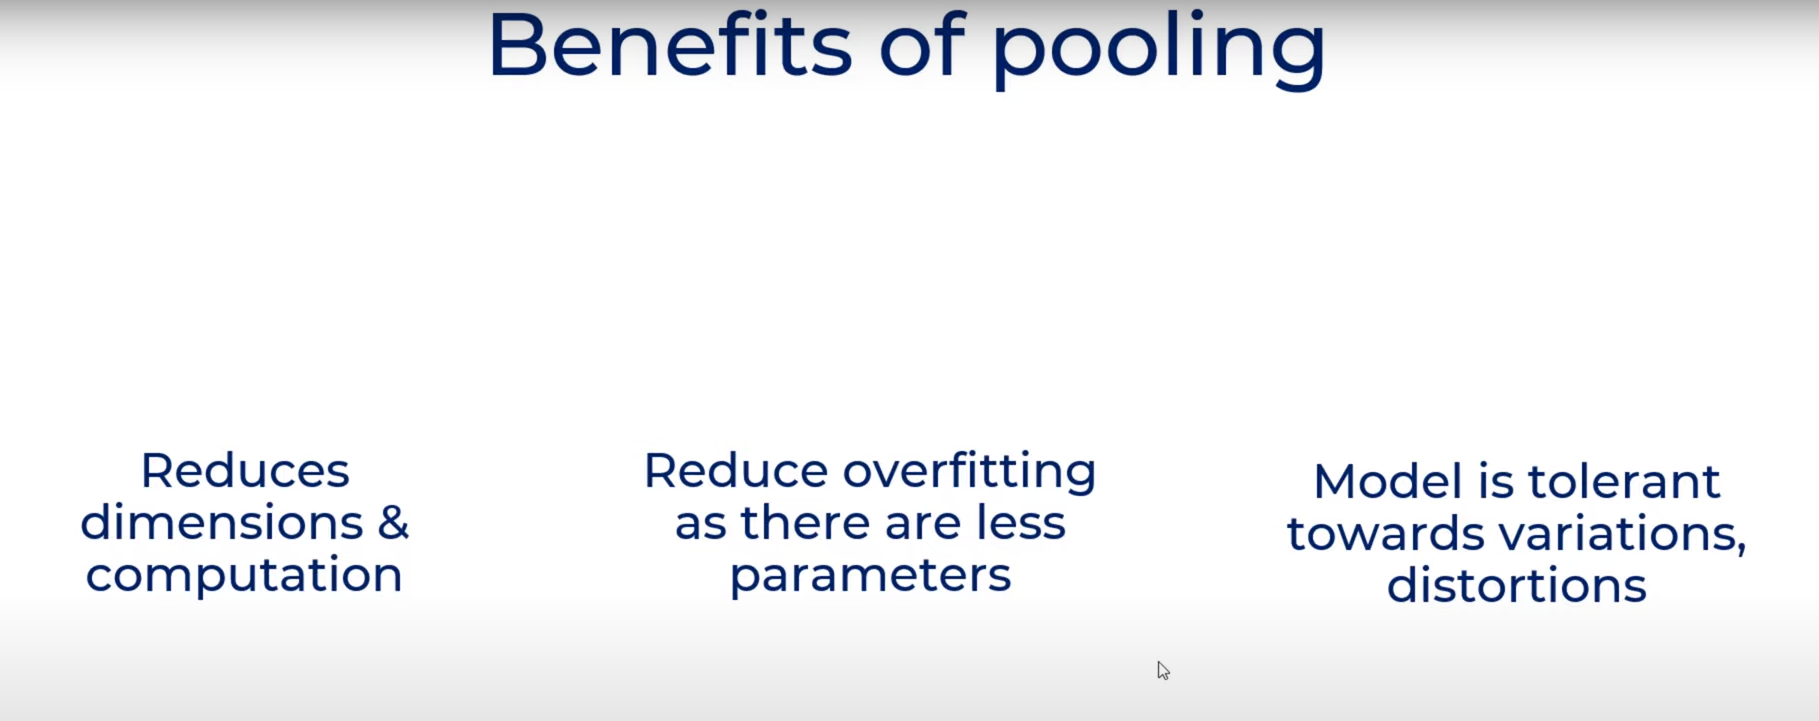

why we use the softmax function ? Before using the output is hard to interpret . After using softmax we change the output to probabilisticic interpretation. And why we use e here . As far as i know , when we use e here , the way we calculate the derivative is much easier when doing backpropagation.

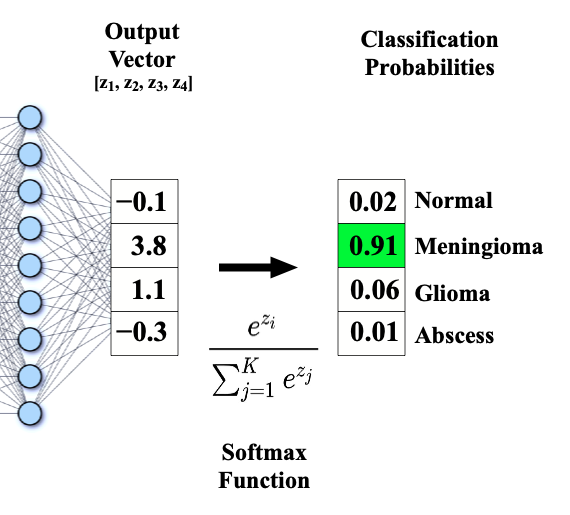

why we use cross-entropy loss? It is often go hand-in-hand with the softmax function . Moreover , the loss will increase significantly when the model predict wrong . And the function is smoother (it make we can take derivativation easily) than using the MQE .

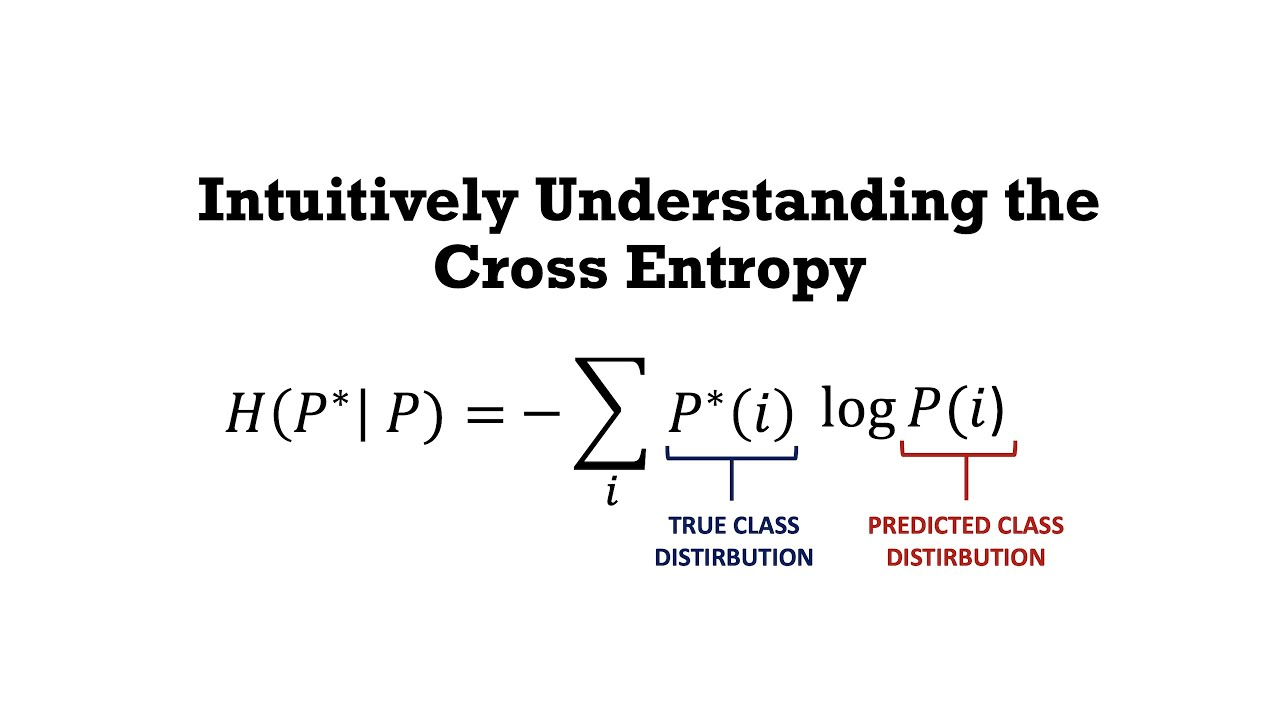

 Adjust the learning rate while training the model. This improve convergence becasue if after 2 epcohs the accuracy doesnot change much, it reduces the learning rate by 0.5 and the minimum value for learning rate is 0.00001

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.6, min_lr=0.000001)

In [ ]:
model = Sequential()

#Convolution
model.add(Conv2D(filters=75,kernel_size=(4, 4), input_shape=(28, 28, 1), activation="relu"))
model.add(BatchNormalization())
#Max-polling
model.add(MaxPool2D(pool_size=(2, 2), strides=2))

#Convolution
model.add(Conv2D(75 , (3,3) , strides = 1 , activation = 'relu'))
model.add(BatchNormalization())
#Max-polling
model.add(MaxPool2D((2,2) , strides = 2 ))

#Convolution
model.add(Conv2D(75 , (3,3) , strides = 1 , activation = 'relu'))
#Max-polling
model.add(MaxPool2D((2,2) , strides = 2 ))

#flltten mean me change the matrix in to a single vector
model.add(Flatten())

#hidden layer 1
model.add(Dense(128, activation="relu"))
# each node has 10% probability that will drop out . In other word, it will be set to zero . It will prevent overfiting
model.add(Dropout(0.1))
#hidden layer 2
model.add(Dense(128, activation="relu"))
#output
model.add(Dense(25, activation="softmax"))

#adam is agorithm that combine the momentum gradient descent and RMSprop ( Adaptively Adjusts Learning Rates by using RMSprop and accelerate the convergence by using momentum GD)
model.compile(optimizer="adam",
               loss='categorical_crossentropy',
               metrics=['accuracy'])

history = model.fit(datagen_CNN.flow(X_train_CNN,y_train_CNN, batch_size = 128) ,epochs = 25 , validation_data = (X_validation_CNN, y_valdidation_CNN), callbacks = [learning_rate_reduction])

print(history)
print(model.summary())

In [ ]:
plot_model(model, to_file='cnn_model.png', show_shapes=True, show_layer_names=True, dpi = 300)

# Display the image
img = plt.imread('cnn_model.png')
plt.figure(figsize=(20, 20))
plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
from sklearn.metrics import classification_report


predicionts = model.predict(X_test_CNN)
y_pred = np.argmax(predicionts, axis=1)

print(type(y_pred[0]))
print(classification_report(y_test, y_pred))

As we can see the accuracy and all the other performance metrics is nearly 100% . The CNN works quite well and efficiency especially with image even if we don't apply any preprocessing technique . It learn which is the important feature to classtificate the letter by themselves .

In [ ]:
epochs = [i for i in range(25)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(16,9)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [ ]:
map_output = {
    0:"A",
    1:"B",
    2:"C",
    3:"D",
    4:"E",
    5:"F",
    6:"G",
    7:"H",
    8:"I",
    9:"None",
    10:"K",
    11:"L",
    12:"M",
    13:"N",
    14:"O",
    15:"P",
    16:"Q",
    17:"R",
    18:"S",
    19:"T",
    20:"U",
    21:"V",
    22:"W",
    23:"X",
    24:"Y",
    25:"None",
}

In [ ]:
i = 100
j = 1
plt.figure(figsize=(8, 6))
for prediction in y_pred[100:100+6]:
    plt.subplot(3,2,j)
    plt.imshow(X_test[i].reshape(28,28), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(map_output[prediction.item()], map_output[y_test[i]]))
    plt.tight_layout()
    i += 1
    j += 1
plt.show()

In [ ]:
i = 0
j = 1
plt.figure(figsize=(8, 6))
for prediction in y_pred[0:6]:
    plt.subplot(3,2,j)
    plt.imshow(X_test[i].reshape(28,28), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(map_output[prediction.item()], map_output[y_test[i]]))
    plt.tight_layout()
    i += 1
    j += 1

plt.show()